# Colab setup
## The first step is not neccesary now, as I fixed all the bad errors
1. Install python 3.10. Please reload page (Ctrl + r / F5) after the first cell
2. Then, clone the repo into the colab

In [ ]:
!wget https://github.com/korakot/kora/releases/download/v0.10/py310.sh
!bash ./py310.sh -b -f -p /usr/local
!python -m ipykernel install --name "py310" --user

In [1]:
!git clone https://github.com/pmozil/discrete_lab_3
%cd discrete_lab_3
!python -m pip install -r requirements.txt

Cloning into 'discrete_lab_3'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 90 (delta 43), reused 67 (delta 20), pack-reused 0
Unpacking objects: 100% (90/90), 103.89 KiB | 2.16 MiB/s, done.
/content/discrete_lab_3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
%cd graphs
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
import queue
import heapq
import time
from sklearn import datasets

from tqdm import tqdm
from itertools import product
from typing import Tuple, Iterator, List
from sklearn.tree import (
    DecisionTreeClassifier as SklearnDecisionTreeClassifier,
)

from graph_generation import gnp_random_connected_graph, draw_graph

[Errno 2] No such file or directory: 'graphs'
/content/discrete_lab_3/graphs


# Prim's algorithm
Here's a naive implementation using a binary heap. It's logarithmic, at least

In [3]:
def prim(graph: nx.Graph) -> nx.Graph:
    """
    Create a spanning tree for the graph

    Args:
        graph: nx.Graph - the given graph

    Returns:
        nx.Graph - the spanning tree
    """
    pqueue = []
    nodes = graph.nodes()
    spanning_tree = nx.Graph()
    for edge in graph.edges(data=True):
        heapq.heappush(pqueue, (edge[0], edge[1]))
    visited = [0 for _ in nodes]
    min_edge = heapq.heappop(pqueue)
    spanning_tree.add_edge(*min_edge)
    visited[min_edge[0]] = 1
    visited[min_edge[1]] = 1
    while not pqueue and not all(visited):
        min_edge = heapq.heappop(pqueue)
        if (visited[min_edge[0]]) ^ (visited[min_edge[1]]):
            spanning_tree.add_edge(*min_edge)
            visited[min_edge[0]] = 1
            visited[min_edge[1]] = 1
    return spanning_tree

A bit slow, but it'll do. On to comparing it with the networkx algorithm!

In [4]:
ITERATIONS = 100
time_taken_networkx = 0
time_taken_native = 0
for i in tqdm(range(ITERATIONS)):
    G = gnp_random_connected_graph(250, 0.2)
    start = time.time()
    nx.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()

    time_taken_networkx += end - start

    start = time.time()
    prim(G)
    end = time.time()

    time_taken_native += end - start

time_taken_native = time_taken_native / ITERATIONS
time_taken_networkx = time_taken_networkx / ITERATIONS

print(f"native: {time_taken_native}s")
print(f"networkx: {time_taken_networkx}s")
print(f"relative: {time_taken_native / time_taken_networkx}")


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]

native: 0.030673773288726808s
networkx: 0.0701137638092041s
relative: 0.43748576060183125


## TODO: add kruskal

# Floyd's algorithm
On to the Floyd's algorithm now. Here's out code:

In [14]:
def floyd(graph: nx.Graph) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate the distance matrix for a graph

    Args:
        graph: nx.Graph - the directed graph

    Returns:
        tuple[np.ndarray, np.ndarray] - the W and Θ matrixes
    """
    graph = graph.to_directed()
    nodes = np.intp(graph.number_of_nodes())
    distances = nx.to_numpy_array(graph, None, weight="weight", nonedge=np.inf)
    np.fill_diagonal(distances, 0)
    source_nodes = np.zeros_like(distances)

    for k in range(nodes):
        if any(distances[i, i] < 0 for i in range(nodes)):
            print("Negative cycle in the graph!")
            raise ValueError
        dist_fst = distances[k]
        for i in range(nodes):
            dist_snd = distances[i]
            for j in range(nodes):
                new_val = dist_snd[k] + dist_fst[j]
                if new_val < distances[i, j]:
                    distances[i, j] = new_val
                    source_nodes[j, i] = k

    return distances, source_nodes


def floyd_with_numpy(graph: nx.Graph) -> np.ndarray:
    """
    Calculate the distance matrix for a graph, with numpy minimum
        (it should be faster)

    Args:
        graph: nx.Graph - the directed graph

    Returns:
        np.ndarray - the W and Θ matrixes
    """
    graph = graph.to_directed()
    distances = nx.to_numpy_array(graph, None, weight="weight", nonedge=np.inf)
    np.fill_diagonal(distances, 0)

    for i in range(distances.shape[0]):
        distances = np.minimum(
            distances,
            distances[i, :][np.newaxis, :] + distances[:, i][:, np.newaxis],
        )

    return distances

I shamelessly stole the second one from the networkx code. It's ingenious!a
Still like 2x slower than the networkx implementation, even though the code is identicalo
Let's look at the times:

In [ ]:

ITERATIONS = 1000
time_taken_networkx = 0
time_taken_native = 0
for i in tqdm(range(ITERATIONS)):
    G = gnp_random_connected_graph(40, 0.2)
    if nx.negative_edge_cycle(G):
        continue
    start = time.time()
    a = nx.floyd_warshall_numpy(G)
    end = time.time()

    time_taken_networkx += end - start

    start = time.time()
    b = floyd_with_numpy(G)
    end = time.time()

    time_taken_native += end - start

time_taken_native = time_taken_native / ITERATIONS
time_taken_networkx = time_taken_networkx / ITERATIONS

print(f"native: {time_taken_native}s")
print(f"networkx: {time_taken_networkx}s")
print(f"relative: {time_taken_native / time_taken_networkx}")

# Time complexities and plots
Plotting stuff on a cartesian plane is almost like mediation, so let's do that

100%|██████████| 62/62 [00:46<00:00,  1.34it/s]


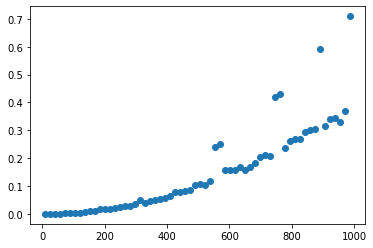

In [13]:
counts = list(range(10, 1000, 16))
times = []
for vert in tqdm(counts): # Vertice counts
    grp = gnp_random_connected_graph(vert, 100)
    start = time.time()
    prim(grp)
    times.append(time.time() - start)
plt.scatter(counts, times)

Say fot the outliars with tons of vertices, it's logarithmic.
Same goes for the floyd's algoritm (I'll be using numpy, so as not to die of olt age while running this)

100%|██████████| 62/62 [04:09<00:00,  4.03s/it]


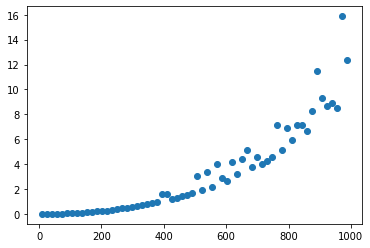

In [15]:
counts = list(range(10, 1000, 16))
times = []
for vert in tqdm(counts): # Vertice counts
    grp = gnp_random_connected_graph(vert, 100)
    start = time.time()
    floyd_with_numpy(grp)
    times.append(time.time() - start)
plt.scatter(counts, times)

... Now imagine that the non-numpy one runs 80x slower >:-[. 
Anyways, it's ± cubic, as expected. You could calculate to be sure but nah...

# Decision trees

Now, the algorithm for the decision tree is fairly simple: pick the column, which has the best distribution of results (by distribution here i mean that the probability of landing on an expected value after comparing the threshold is high. For that one may use entropy or gini, or something more complicated, but for our simple case simple gini will suffice), and set it as the next node.
Anything below the threshold goes left, and anythig above it goes right. Repeat the process until the tree max depth is reached, and be happy. That's it

Now, on to the code

In [19]:
class Node:
    """A decision tree node.

    Parameters:
        gini: float - the node's gini value
        samples: int - the amount of samples used for fitting
        samples_per_self: int - the same as samples,
            but filters bad data
        targets: np.ndarray - the class to be predicted
        threshold: float - the criterion for going left or right
        left: Node | None - the left leaf
        right: Node | Node - the right leaf
    """

    def __init__(
        self,
        gini: float,
        samples: int,
        samples_per_self: list,
        targets: np.intp
    ) -> None:
        """
        Init for the Node class

        Args:
            gini: float - the node's gini value
            samples: int - the amount of samples used for fitting
            samples_per_self: int - the same as samples,
                but filters bad data
            targets: np.ndarray - the class to be predicted
        """
        self.gini = gini
        self.samples = samples
        self.samples_per_self = samples_per_self
        self.targets: np.intp = targets
        self._feature_index: int = 0
        self._threshold = 0
        self._left = None
        self._right = None

    def print_gini(self):
        print(self.gini)
        if self._left is not None:
            self._left.print_gini()
        if self._right is not None:
            self._right.print_gini()


    @property
    def feature_index(self) -> int:
        """
        Getter for self.feature_index
        """
        return self._feature_index

    @feature_index.setter
    def feature_index(self, feature_index: int) -> None:
        """
        Setter for feature_index

        Args:
            feature_index: float
        """
        self._feature_index = feature_index

    @property
    def threshold(self) -> float:
        """
        Getter for self._threshold
        """
        return self._threshold

    @threshold.setter
    def threshold(self, threshold: float) -> None:
        """
        Setter for self._threshold

        Args:
            threshold: float
        """
        self._threshold = threshold

    @property
    def left(self) -> "Node":
        """
        Getter for self._left
        """
        return self._left

    @left.setter
    def left(self, left: "Node") -> None:
        """
        Setter for self._left

        Args:
            left: Node | None
        """
        self._left = left

    @property
    def right(self) -> "Node":
        """
        Getter for self._right
        """
        return self._right

    @right.setter
    def right(self, right: "Node") -> None:
        """
        Setter for self._right

        Args:
            right: Node | None
        """
        self._right = right

Be not afraid, that's just the setters/getters for the node. Otherwise, the class is fairly simple. Now, on to the tree itself

In [46]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int = 16, min_predictions: int = 20) -> None:
        self._max_depth = max_depth
        self._min_predictions = min_predictions

    def fit(self, features: np.ndarray, targets: np.ndarray) -> None:
        """
        Grow the tree from given data

        Args:
            features: np.ndarray - the array of features
            targets: np.ndarray - the araay of features to split by
        """
        # classes are assumed to go from 0 to n-1
        self._classes = len(set(targets))
        self._features_len = features.shape[1]
        self._features = features
        self._targets = targets
        self._tree = self.build_tree(features, targets)

    def predict(self, object_features: np.ndarray) -> list:
        """
        Predict the value for given features

        Args:
            object_features: np.ndarray - the features of specific object
        """
        return [self._predict(inputs) for inputs in object_features]

    def _gini(self, targets):
        """Compute Gini for a node.

        Args:
            targets: np.ndarray
        """
        m = targets.size
        return 1.0 - sum(
            (np.sum(targets == c) / m) ** 2 for c in range(self._classes)
        )

    def split_data(
        self, features: np.ndarray, targets: np.ndarray
    ) -> Tuple[int, float]:
        """Find the best split for a node.

        Args:
            features: np.ndarray - the array of features
            targets: np.ndarray - the array of targets (results)

        Returns:
            tuple[int, float] - the pair with the index of
                feature and threshold
        """
        m = targets.size
        if m <= 1:
            return -1, -1

        parent_counts = [np.sum(targets == c) for c in range(self._classes)]

        best_gini = 1.0 - sum((n / m) ** 2 for n in parent_counts)
        id, thr = -1, -1

        for idx in range(self._features_len):
            thresholds, classes = zip(*sorted(zip(features[:, idx], targets)))

            lefts = [0] * self._classes
            rights = parent_counts.copy()
            for i in range(1, m):
                c = int(classes[i - 1])
                lefts[c] += 1
                rights[c] -= 1
                gini_left = 1.0 - sum(
                    (lefts[x] / i) ** 2 for x in range(self._classes)
                )
                gini_right = 1.0 - sum(
                    (rights[x] / (m - i)) ** 2 for x in range(self._classes)
                )

                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    id = idx
                    thr = (thresholds[i] + thresholds[i - 1]) / 2

        return id, float(thr)

    def build_tree(
        self, features: np.ndarray, targets: np.ndarray, depth: int = 0
    ) -> Node:
        """
        Recursively construct the tree

        Args:
            features: np.ndarray - the array of features
            target: np.ndarray - the array of targets (results)
            depth: int - the current tree depth
        """
        samples_per_self = [np.sum(targets == i) for i in range(self._classes)]
        preds = np.argmax(samples_per_self)
        node = Node(
            gini=self._gini(targets),
            samples=targets.size,
            samples_per_self=samples_per_self,
            targets=preds,
        )

        if (
            depth < self._max_depth
            and samples_per_self[preds] >= self._min_predictions
        ):
            idx, thr = self.split_data(features, targets)
            indices_left = features[:, idx] < thr
            features_left, targets_left = (
                features[indices_left],
                targets[indices_left],
            )
            features_right, targets_right = (
                features[~indices_left],
                targets[~indices_left],
            )
            node.feature_index = idx
            node.threshold = thr
            node.left = self.build_tree(features_left, targets_left, depth + 1)
            node.right = self.build_tree(
                features_right, targets_right, depth + 1
            )
        return node

    @property
    def accuracy(self) -> float:
        """
        Evaluate the tree's accuracy

        Returns:
            float: the tree's accuracy
        """
        if self._tree is None:
            return 0
        num_guessed = 0
        for ind, input in enumerate(self._features):
            pred = self.predict([input])[0]
            if pred == self._targets[ind]:
                num_guessed += 1
        return num_guessed / len(self._targets)

    def _predict(self, object_features: np.ndarray) -> np.intp:
        """
        Predict the class for a single sample

        Args:
            object_features: np.ndarray - the features of a single object
        """
        if self._tree is None:
            raise ValueError
        node = self._tree
        while node.left is not None:
            node = (
                node.left
                if object_features[node.feature_index] < node.threshold
                else node.right
            )
        return node.targets

Everything should be quite straightforward, if only for the recursive tree growing. In it, we split the given features by the threshold, and, as already mentioned, we feed the values below the threshold to the node on the left, and all the other data (see `features[~indices_left]`) to the node on the right.
There's also an guesser for the optimal tree values (max_depth and min_predictions), but it's really just bruteforcing, so i'll just leave it here

In [34]:
class Estimator:
    def __init__(
        self,
        features: np.ndarray,
        targets: np.ndarray,
        min_predictions: List[int] = [5, 10, 20],
        max_depth: List[int] = [3, 5, 10, 16],
    ) -> None:
        """
        Init fot eh Estimator

        Args:
        """
        self.min_predictions = min_predictions
        self.max_depth = max_depth
        self.features = features
        self.targets = targets

    @property
    def _next_tree(self) -> Iterator[DecisionTreeClassifier]:
        """
        Train the next Tree so as to check all their accuracies

        Returns:
            DecisionTreeClassifier - the next tree with the new arguments
        """
        for depth, preds in product(self.max_depth, self.min_predictions):
            tree = DecisionTreeClassifier(
                max_depth=depth,
                min_predictions=preds,
            )
            tree.fit(self.features, self.targets)
            yield tree

    @property
    def best_tree(self) -> DecisionTreeClassifier:
        """
        Find best tree for the given predictions and depths

        Returns:
            DecisionTreeClassifier - the best tree
        """
        trees = self._next_tree
        accuracy = -1
        for tree in trees:
            if tree.accuracy > accuracy:
                cur_tree = tree
                accuracy = tree.accuracy
        return cur_tree

Let's see how it all works. We'll be using the breast cancer dataset. It has plenty of features, and is sufficiently big for our use case

In [48]:
dataset = datasets.load_breast_cancer()
feats, targets = dataset.data, dataset.target

estimator = Estimator(
    features=feats,
    targets=targets,
    max_depth=list(range(2, 10)),
    min_predictions=list(range(2, 20, 4))
)

clf_sklearn = SklearnDecisionTreeClassifier()
clf_sklearn.fit(feats, targets)

clf = estimator.best_tree
print(f"Tree accuracy: {clf.accuracy}")
count = 0
for _ in range(1000):
    input = [np.random.rand() for _ in range(30)]
    pred = clf.predict([input])[0]
    pred_sklearn = clf_sklearn.predict([input])[0]
#     print(
#         f"""
# Prediction: {dataset.target_names[pred]}; \
# Sklearn prediction: {dataset.target_names[pred_sklearn]}
#     """
#     )
    if pred == pred_sklearn:
        count += 1
print(f"Accuracy (compared with the sklearn tree): {count / 1000}")

<ipython-input-46-6f9c2bd1a73f>:38: RuntimeWarning: invalid value encountered in long_scalars
  (np.sum(targets == c) / m) ** 2 for c in range(self._classes)


Tree accuracy: 1.0
Accuracy (compared with the sklearn tree): 0.979
